<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C2/C2.html"><img src="../data/C2_nav.png" width="100"  style="float:right;" alt="C2"></a>
<h1>STFT: Frequency Grid Density</h1> 
</div>

<br/>

<p>
Computing a discrete STFT introduces a frequency grid which resolution depends on the signal's sampling rate and the STFT window size, see Section 2.1.4 of  <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>. In this notebook, we discuss how to make the frequency grid denser by suitably padding the windowed sections in the STFT computation. <font color="red"><strong>Often, one loosely says that this procedure increases the frequency resolution. This, however, is not true in a qualitative sense as we explain below.</strong> </font>  
</p> 

## DFT Frequency Grid

Let $x\in \mathbb{R}^N$ be discrete signal of length $N\in\mathbb{N}$ with samples $x(0), x(1), \ldots, x(N-1)$. Given the sampling rate $F_\mathrm{s}$, we assume that $x$ is obtained by sampling a continues-time signal $f:\mathbb{R}\to\mathbb{R}$. Then, the **discrete Fourier transform** (DFT) $X := \mathrm{DFT}_N \cdot x$ can be interpreted as an approximation of the continuous Fourier transform  $\hat{f}$ for certain frequencies (see Equation (2.132) of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>):

$$ 
X(k) := \sum_{n=0}^{N-1} x(n) \exp(-2 \pi i k n / N) 
\approx {F_\mathrm{s}} \cdot \hat{f} \left(k \cdot \frac{F_\mathrm{s}}{N}\right)
$$

for $k\in[0:N-1]$. Thus, the index $k$ of $X(k)$ corresponds to the physical frequency

\begin{equation}
         F_\mathrm{coef}^N(k) := \frac{k\cdot F_\mathrm{s}}{N} 
\end{equation}

given in Hertz. In other words, the discrete Fourier transform introduces a linear **frequency grid** of resolution $F_\mathrm{s}/N$, which depends on the size $N$ of the $\mathrm{DFT}_N$. To increase the density of the frequency grid, one idea is to increase the size of the DFT by artificially appending zeros to the signal. To this end, let $L\in\mathbb{N}$ with $L\geq N$. Then, we apply **zero padding** to the right of the signal $x$ obtaining the signal $\tilde{x}\in \mathbb{R}^L$:

\begin{equation}
\tilde{x}(n) :=\left\{\begin{array}{ll}
    x(n) ,& \,\,\mbox{for}\,\, n \in[0:N-1],\\
    0,    & \,\,\mbox{for}\,\, n \in[N:L-1].
\end{array}\right.    
\end{equation}

Applying a $\mathrm{DFT}_L$, we obtain:

$$ 
\tilde{X}(k) = \mathrm{DFT}_L \cdot \tilde{x}
= \sum_{n=0}^{L-1} \tilde{x}(n) \exp(-2 \pi i k n / L)
= \sum_{n=0}^{N-1} x(n) \exp(-2 \pi i k n / L)
\approx {F_\mathrm{s}} \cdot \hat{f} \left(k \cdot \frac{F_\mathrm{s}}{L}\right)
$$

for $k\in[0:L-1]$. The coefficient $\tilde{X}(k)$ now corresponds to the physical frequency

\begin{equation}
         F_\mathrm{coef}^L(k) := \frac{k\cdot F_\mathrm{s}}{L},
\end{equation}

thus introducing a linear frequency resolution of $F_\mathrm{s}/L$. For example, if $L=2N$, the frequency grid resolution is increased by a factor of $2$. In other words, the longer DFT results in more frequency bins that are more closely spaced. However, note that <font color="red"><strong>this trick does not improve the approximation quality of the DFT</strong> </font> (note that the number of summands in the Riemann approximation is still $N$). Only, the linear sampling of the frequency axis is refined when using $L\geq N$ and zero padding. The following example compares $\mathrm{DFT}_N \cdot x$ with $\mathrm{DFT}_L \cdot \tilde{x}$. 

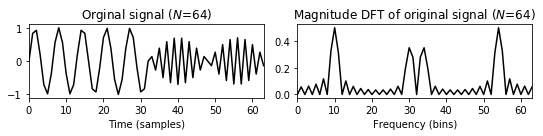

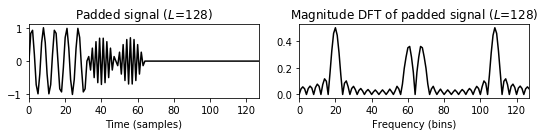

In [1]:
import numpy as np
from  matplotlib import pyplot as plt
import librosa
%matplotlib inline

Fs = 32
duration = 2
freq1 = 5
freq2 = 15
N = int(duration * Fs)
t = np.arange(N) / Fs
t1 = t[:N//2]
t2 = t[N//2:]

x1 = 1.0 * np.sin(2 * np.pi * freq1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * freq2 * t2)
x = np.concatenate((x1, x2))

plt.figure(figsize=(8, 2))

ax1 = plt.subplot(1, 2, 1)
plt.plot(x, c='k')
plt.title('Orginal signal ($N$=%d)' % N)
plt.xlabel('Time (samples)')
plt.xlim([0, N - 1])
plt.subplot(1, 2, 2)
Y = np.abs(np.fft.fft(x)) / Fs
plt.plot(Y, c='k')
plt.title('Magnitude DFT of original signal ($N$=%d)' % N)
plt.xlabel('Frequency (bins)')
plt.xlim([0, N - 1])
plt.tight_layout()

L = 2 * N
pad_len = L - N
t_tilde = np.concatenate((t, np.arange(len(x), len(x) + pad_len) / Fs))
x_tilde = np.concatenate((x, np.zeros(pad_len)))
                         
plt.figure(figsize=(8, 2))
ax1 = plt.subplot(1, 2, 1)
plt.plot(x_tilde, c='k')
plt.title('Padded signal ($L$=%d)' % L)
plt.xlabel('Time (samples)')
plt.xlim([0, L - 1])
plt.subplot(1, 2, 2)
Y_tilde = np.abs(np.fft.fft(x_tilde)) / Fs
plt.plot(Y_tilde, c='k')
plt.title('Magnitude DFT of padded signal ($L$=%d)' % L)
plt.xlabel('Frequency (bins)')
plt.xlim([0, L - 1])

plt.tight_layout()                       

The next code example implements a function for computing the DFT with increased frequency grid resolution, where all parameters are interpreted in a physical way (in terms of seconds and Hertz).

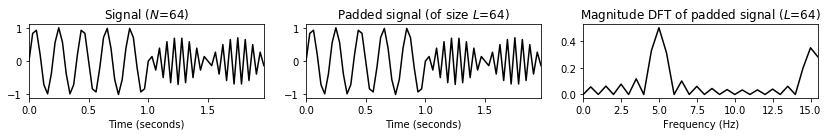

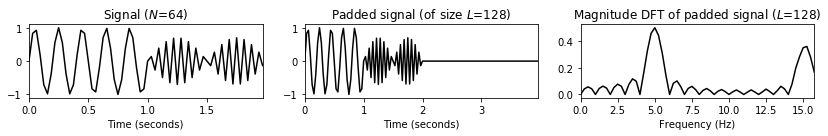

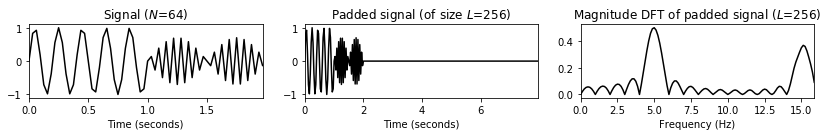

In [2]:
def compute_plot_DFT_extended(t, x, Fs, L):
    N = len(x)
    pad_len = L - N
    t_tilde = np.concatenate((t, np.arange(len(x), len(x) + pad_len) / Fs))
    x_tilde = np.concatenate((x, np.zeros(pad_len)))
    Y = np.abs(np.fft.fft(x_tilde)) / Fs    
    Y = Y[:L//2]
    freq = np.arange(L//2)*Fs/L
    # freq = np.fft.fftfreq(L, d=1/Fs)
    # freq = freq[:L//2]
    plt.figure(figsize=(12, 2))
    
    ax1 = plt.subplot(1, 3, 1)
    plt.plot(t_tilde, x_tilde, c='k')
    plt.title('Signal ($N$=%d)' % N)
    plt.xlabel('Time (seconds)')
    plt.xlim([t[0], t[-1]])
    
    ax2 = plt.subplot(1, 3, 2)
    plt.plot(t_tilde, x_tilde, c='k')
    plt.title('Padded signal (of size $L$=%d)' % L)
    plt.xlabel('Time (seconds)')
    plt.xlim([t_tilde[0], t_tilde[-1]])    
    
    ax3 = plt.subplot(1, 3, 3)
    plt.plot(freq, Y, c='k')
    plt.title('Magnitude DFT of padded signal ($L$=%d)' % L)
    plt.xlabel('Frequency (Hz)')
    plt.xlim([freq[0], freq[-1]])
    plt.tight_layout()           

    return ax1, ax2, ax3

    
N = len(x)

L = N
ax1, ax2, ax3 = compute_plot_DFT_extended(t, x, Fs, L)

L = 2 * N
ax1, ax2, ax3 = compute_plot_DFT_extended(t, x, Fs, L)

L = 4 * N
ax1, ax2, ax3 = compute_plot_DFT_extended(t, x, Fs, L)

## STFT with Increased Frequency Grid Resolution

We now show how the same zero-padding strategy can be used to increase the frequency grid resolution of an STFT. The `librosa` function `librosa.stft` implements this idea by means of the two parameters `n_fft` (corresponding to $L$) and `win_length` (corresponding to $N$). Care has to be taken when converting the parameters to the physical domain. Our example is the note C4 played by a violin (with vibrato).

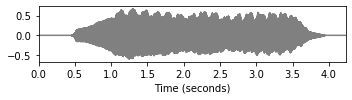

In [3]:
import os
import IPython.display as ipd

# Load wav
fn_wav = os.path.join('..', 'data', 'C2', 'FMP_C2_F05c_C4_violin.wav')

Fs = 11025
x, Fs = librosa.load(fn_wav, sr=Fs)
ipd.display(ipd.Audio(x, rate=Fs))

t_wav = np.arange(0, x.shape[0]) * 1 / Fs
plt.figure(figsize=(5, 1.5))
plt.plot(t_wav, x, c='gray')
plt.xlim([t_wav[0], t_wav[-1]])
plt.xlabel('Time (seconds)')
plt.tight_layout()

We now compute an STFT with zero-padding. In the visualization, the axis are shown in terms of time frames and frequency bins. 

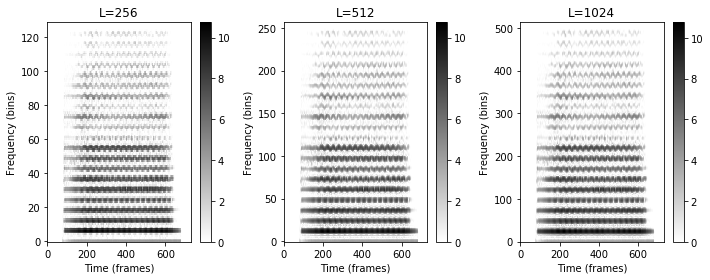

In [4]:
def compute_stft(x, Fs, N, H, L=N, pad_mode='constant', center=True):    
    X = librosa.stft(x, n_fft=L, hop_length=H, win_length=N, 
                     window='hann', pad_mode=pad_mode, center=center)
    Y = np.log(1 + 100 * np.abs(X) ** 2)
    F_coef = librosa.fft_frequencies(sr=Fs, n_fft=L)
    T_coef = librosa.frames_to_time(np.arange(X.shape[1]), sr=Fs, hop_length=H) 
    return Y, F_coef, T_coef

def plot_compute_spectrogram(x, Fs, N, H, L, color='gray_r'):
    Y, F_coef, T_coef = compute_stft(x, Fs, N, H, L)
    plt.imshow(Y, cmap=color, aspect='auto', origin='lower')
    plt.xlabel('Time (frames)')
    plt.ylabel('Frequency (bins)')
    plt.title('L=%d' % L)
    plt.colorbar()
    
N = 256
H = 64
color = 'gray_r' 
plt.figure(figsize=(10, 4))

L = N
plt.subplot(1,3,1)
plot_compute_spectrogram(x, Fs, N, H, L)

L = 2 * N
plt.subplot(1,3,2)
plot_compute_spectrogram(x, Fs, N, H, L)

L = 4 * N
plt.subplot(1,3,3)
plot_compute_spectrogram(x, Fs, N, H, L)

plt.tight_layout()

Next, we repeat the same computation, where the axis are now converted to show physical units specified in seconds and Hertz. Furthermore, we zoom into the time-frequency plane to highlight the effect of having a denser frequency grid density.

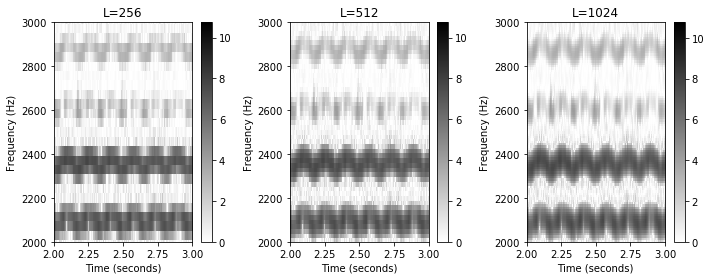

In [5]:
def plot_compute_spectrogram_physical(x, Fs, N, H, L, xlim, ylim, color='gray_r'):
    Y, F_coef, T_coef = compute_stft(x, Fs, N, H, L)
    extent=[T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]]
    plt.imshow(Y, cmap=color, aspect='auto', origin='lower', extent=extent)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.title('L=%d' % L)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.colorbar()

xlim_sec = [2, 3]
ylim_hz = [2000, 3000]

plt.figure(figsize=(10, 4))

L = N
plt.subplot(1,3,1)
plot_compute_spectrogram_physical(x, Fs, N, H, L, xlim=xlim_sec, ylim=ylim_hz)

L = 2 * N
plt.subplot(1,3,2)
plot_compute_spectrogram_physical(x, Fs, N, H, L, xlim=xlim_sec, ylim=ylim_hz)

L = 4 * N
plt.subplot(1,3,3)
plot_compute_spectrogram_physical(x, Fs, N, H, L, xlim=xlim_sec, ylim=ylim_hz)

plt.tight_layout()

## Further Notes

* As an alternative, we discuss in the <a href="../C2/C2_STFT-FreqGridInterpol.html">FMP notebook on frequency interpolation</a> how one can change and adapt the linear frequency grid (as introduced by the discrete STFT) using standard interpolation techniques. 

* A summary of the STFT variant as used for most parts in the FMP notebook can be found in the <a href="../C2/C2_STFT-Conventions.html">FMP notebook on STFT conventions and implementations.</a>

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.
</div>  

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>